# Fit Smoothed Disperser Attenuation Ratio study for HD160617


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [160]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [161]:
#from IPython.core.display import HTML
#def css_styling():
#    styles = open("../../styles/custom.css", "r").read()
#    return HTML(styles)
#css_styling()

### import

In [162]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [163]:
from scipy import interpolate

In [164]:
import seaborn as sns

In [165]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [166]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [167]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [168]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [169]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [170]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [171]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [172]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [173]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [174]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [175]:
home=os.getenv('HOME')

In [176]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [177]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [178]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [179]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [180]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [181]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [182]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [183]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2')

In [184]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2'

## Selection of night

In [185]:
date="20170612"

In [186]:
idx_sel_subdir=12

In [187]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [188]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [189]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [190]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [191]:
wlshift.head()

index  wlshift
0     51      7.0
1     52      1.0
2     53      2.0
3     54     -1.0
4     55      4.0

### path for spectra

In [192]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [193]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [194]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [195]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [196]:
sel_obs.head()

index    P     T  RH airmass seeing exposure  \
date                                                                    
2017-06-13T00:24:20.451     41  779  10,8   0   1,239  0,792      600   
2017-06-13T00:58:25.646     42  779  10,5  31   1,156  0,892     3600   
2017-06-13T02:23:08.847     44  779   9,7   0   1,072  1,042     3600   
2017-06-13T06:12:16.748     48  779   9,3   0   1,051  1,049       30   
2017-06-13T06:13:39.453     49  779   9,2   0   1,052  1,049       30   

                              object filter disperser  focus     W  \
date                                                                 
2017-06-13T00:24:20.451  PKS1510-089    dia   HoloPhP  12300  12,3   
2017-06-13T00:58:25.646  PKS1510-089    dia   HoloPhP  12300  13,1   
2017-06-13T02:23:08.847  PKS1510-089    dia  HoloPhAg  12300  14,4   
2017-06-13T06:12:16.748     HD160617  FGB37   Thor300  12400    19   
2017-06-13T06:13:39.453     HD160617  FGB37   HoloPhP  12400  19,7   

                               subdir                     file  
date                                                            
2017-06-13T00:24:20.451  data_12jun17  reduc_20170612_041.fits  
2017-06-13T00:58:25.646  data_12jun17  reduc_20170612_042.fits  
2017-06-13T02:23:08.847  data_12jun17  reduc_20170612_044.fits  
2017-06-13T06:12:16.748  data_12jun17  reduc_20170612_048.fits  
2017-06-13T06:13:39.453  data_12jun17  reduc_20170612_049.fits

In [197]:
sel_obs.tail()

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-06-13T09:55:56.351    175  778  9,2  30   1,868  1,049       60   
2017-06-13T09:58:23.806    176  778  9,1  30   1,031  1,049       30   
2017-06-13T09:59:46.505    177  778  9,2  30   1,032  1,049       30   
2017-06-13T10:01:09.099    178  778  9,3   0   1,033  1,049       60   
2017-06-13T10:03:01.553    179  778    9   0   1,035  1,049       60   

                           object filter disperser  focus     W        subdir  \
date                                                                            
2017-06-13T09:55:56.351  HD185975  FGB37  HoloAmAg  12400  27,1  data_12jun17   
2017-06-13T09:58:23.806  HD205905  FGB37   Thor300  12400  26,1  data_12jun17   
2017-06-13T09:59:46.505  HD205905  FGB37   HoloPhP  12400  24,4  data_12jun17   
2017-06-13T10:01:09.099  HD205905  FGB37  HoloPhAg  12400    20  data_12jun17   
2017-06-13T10:03:01.553  HD205905  FGB37  HoloAmAg  12400  19,8  data_12jun17   

                                            file  
date                                              
2017-06-13T09:55:56.351  reduc_20170612_175.fits  
2017-06-13T09:58:23.806  reduc_20170612_176.fits  
2017-06-13T09:59:46.505  reduc_20170612_177.fits  
2017-06-13T10:01:09.099  reduc_20170612_178.fits  
2017-06-13T10:03:01.553  reduc_20170612_179.fits

### Quick view on the kind of sources

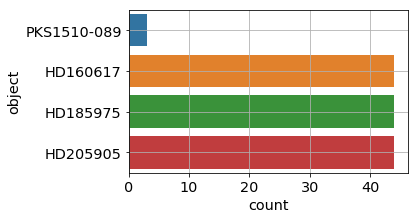

In [198]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

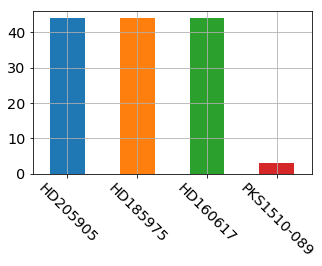

In [199]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [200]:
#bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [201]:
#bad_obs_0

### Remove bad sources

- remove star **PNG336.3-05.6**

In [202]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PKS1510-089','HD205905','HD185975'])]
bad_indexes=bad_obs["index"]

In [203]:
bad_obs

index    P     T  RH airmass seeing exposure  \
date                                                                    
2017-06-13T00:24:20.451     41  779  10,8   0   1,239  0,792      600   
2017-06-13T00:58:25.646     42  779  10,5  31   1,156  0,892     3600   
2017-06-13T02:23:08.847     44  779   9,7   0   1,072  1,042     3600   
2017-06-13T06:19:16.548     52  779   9,4  35   1,859  1,049       30   
2017-06-13T06:20:39.151     53  779   9,3  32   1,859  1,049       30   
2017-06-13T06:22:01.796     54  779   9,3   0   1,859  1,049       60   
2017-06-13T06:23:55.102     55  779   9,4  32   1,858  1,049       60   
2017-06-13T06:26:22.561     56  779   9,5   0   1,189  1,049       30   
2017-06-13T06:27:45.156     57  779   9,4  31   1,185  1,049       30   
2017-06-13T06:29:07.805     58  779   9,4  56   1,182  1,049       60   
2017-06-13T06:31:00.448     59  779   9,5   0   1,176  1,049       60   
2017-06-13T06:40:27.614     64  779   9,4  32   1,855  1,049       30   
2017-06-13T06:41:50.160     65  779   9,2   0   1,855  1,049       30   
2017-06-13T06:43:13.459     66  779   9,3   0   1,855  1,049       60   
2017-06-13T06:45:06.153     67  779   9,5  32   1,854  1,049       60   
2017-06-13T06:47:35.047     68  779   9,5  49   1,135  1,049       30   
2017-06-13T06:48:57.646     69  779   9,5  45   1,132  1,049       30   
2017-06-13T06:50:20.300     70  779   9,5  32   1,128  1,049       60   
2017-06-13T06:52:12.955     71  779   9,2   0   1,124  1,049       60   
2017-06-13T07:01:39.448     76  779   9,4  31   1,852  1,049       30   
2017-06-13T07:03:02.004     77  779   9,4  31   1,852  1,049       30   
2017-06-13T07:04:24.507     78  779   9,4  31   1,852  1,049       60   
2017-06-13T07:06:17.146     79  779   9,4  32   1,852  1,049       60   
2017-06-13T07:08:44.599     80  779   9,4  31   1,091  1,049       30   
2017-06-13T07:10:07.046     81  779   9,6  31   1,089  1,049       30   
2017-06-13T07:11:29.547     82  779   9,5   0   1,087  1,049       60   
2017-06-13T07:13:22.208     83  779   9,5  18   1,083  1,049       60   
2017-06-13T07:22:51.956     88  779   9,4  33    1,85  1,049       30   
2017-06-13T07:24:14.554     89  779   9,4  31    1,85  1,049       30   
2017-06-13T07:25:37.111     90  779   9,5  31    1,85  1,049       60   
...                        ...  ...   ...  ..     ...    ...      ...   
2017-06-13T08:50:27.101    138  779   9,4  31   1,854  1,049       60   
2017-06-13T08:52:19.602    139  778   9,3  39   1,854  1,049       60   
2017-06-13T08:54:47.646    140  778   9,2  32   1,001  1,049       30   
2017-06-13T08:56:10.253    141  779   9,2   0   1,001  1,049       30   
2017-06-13T08:57:32.856    142  778   9,2  31   1,001  1,049       60   
2017-06-13T08:59:25.403    143  778   9,4   0   1,001  1,049       60   
2017-06-13T09:08:53.804    148  778   9,1  31   1,857  1,049       30   
2017-06-13T09:10:16.347    149  778   9,2   0   1,857  1,049       30   
2017-06-13T09:11:38.908    150  778   9,1  31   1,857  1,049       60   
2017-06-13T09:13:31.505    151  778   9,1   0   1,858  1,049       60   
2017-06-13T09:15:59.708    152  778   9,1   0   1,004  1,049       30   
2017-06-13T09:17:22.399    153  778   9,1  31   1,005  1,049       30   
2017-06-13T09:18:44.944    154  778   8,9  35   1,005  1,049       60   
2017-06-13T09:20:37.654    155  778   8,9  50   1,006  1,049       60   
2017-06-13T09:30:05.655    160  778     9   0   1,861  1,049       30   
2017-06-13T09:31:28.248    161  778   9,1  44   1,861  1,049       30   
2017-06-13T09:32:50.954    162  778     9  31   1,862  1,049       60   
2017-06-13T09:34:43.547    163  778     9  31   1,862  1,049       60   
2017-06-13T09:37:10.861    164  778     9  31   1,014  1,049       30   
2017-06-13T09:38:33.506    165  778   8,9  32   1,015  1,049       30   
2017-06-13T09:39:56.057    166  778   8,9   0   1,016  1,049       60   
2017-06-13T09:41:48.650    167  778   8,9  31   1,017  1,049       60   
2017-06-13

In [204]:
bad_indexes=bad_obs.loc[:,"index"]

In [205]:
bad_indexes.index

Index([u'2017-06-13T00:24:20.451', u'2017-06-13T00:58:25.646',
       u'2017-06-13T02:23:08.847', u'2017-06-13T06:19:16.548',
       u'2017-06-13T06:20:39.151', u'2017-06-13T06:22:01.796',
       u'2017-06-13T06:23:55.102', u'2017-06-13T06:26:22.561',
       u'2017-06-13T06:27:45.156', u'2017-06-13T06:29:07.805',
       u'2017-06-13T06:31:00.448', u'2017-06-13T06:40:27.614',
       u'2017-06-13T06:41:50.160', u'2017-06-13T06:43:13.459',
       u'2017-06-13T06:45:06.153', u'2017-06-13T06:47:35.047',
       u'2017-06-13T06:48:57.646', u'2017-06-13T06:50:20.300',
       u'2017-06-13T06:52:12.955', u'2017-06-13T07:01:39.448',
       u'2017-06-13T07:03:02.004', u'2017-06-13T07:04:24.507',
       u'2017-06-13T07:06:17.146', u'2017-06-13T07:08:44.599',
       u'2017-06-13T07:10:07.046', u'2017-06-13T07:11:29.547',
       u'2017-06-13T07:13:22.208', u'2017-06-13T07:22:51.956',
       u'2017-06-13T07:24:14.554', u'2017-06-13T07:25:37.111',
       u'2017-06-13T07:27:29.753', u'2017-06-13T07:29:5

In [206]:
bad_indexes.values

array([ 41,  42,  44,  52,  53,  54,  55,  56,  57,  58,  59,  64,  65,
        66,  67,  68,  69,  70,  71,  76,  77,  78,  79,  80,  81,  82,
        83,  88,  89,  90,  91,  92,  93,  94,  95, 100, 101, 102, 103,
       104, 105, 106, 107, 112, 113, 114, 115, 116, 117, 118, 119, 124,
       125, 126, 127, 128, 129, 130, 131, 136, 137, 138, 139, 140, 141,
       142, 143, 148, 149, 150, 151, 152, 153, 154, 155, 160, 161, 162,
       163, 164, 165, 166, 167, 172, 173, 174, 175, 176, 177, 178, 179])

### Concatenate bad obs

In [207]:
#bad_obs=pd.concat([bad_obs,bad_obs_0])

In [208]:
bad_obs

index    P     T  RH airmass seeing exposure  \
date                                                                    
2017-06-13T00:24:20.451     41  779  10,8   0   1,239  0,792      600   
2017-06-13T00:58:25.646     42  779  10,5  31   1,156  0,892     3600   
2017-06-13T02:23:08.847     44  779   9,7   0   1,072  1,042     3600   
2017-06-13T06:19:16.548     52  779   9,4  35   1,859  1,049       30   
2017-06-13T06:20:39.151     53  779   9,3  32   1,859  1,049       30   
2017-06-13T06:22:01.796     54  779   9,3   0   1,859  1,049       60   
2017-06-13T06:23:55.102     55  779   9,4  32   1,858  1,049       60   
2017-06-13T06:26:22.561     56  779   9,5   0   1,189  1,049       30   
2017-06-13T06:27:45.156     57  779   9,4  31   1,185  1,049       30   
2017-06-13T06:29:07.805     58  779   9,4  56   1,182  1,049       60   
2017-06-13T06:31:00.448     59  779   9,5   0   1,176  1,049       60   
2017-06-13T06:40:27.614     64  779   9,4  32   1,855  1,049       30   
2017-06-13T06:41:50.160     65  779   9,2   0   1,855  1,049       30   
2017-06-13T06:43:13.459     66  779   9,3   0   1,855  1,049       60   
2017-06-13T06:45:06.153     67  779   9,5  32   1,854  1,049       60   
2017-06-13T06:47:35.047     68  779   9,5  49   1,135  1,049       30   
2017-06-13T06:48:57.646     69  779   9,5  45   1,132  1,049       30   
2017-06-13T06:50:20.300     70  779   9,5  32   1,128  1,049       60   
2017-06-13T06:52:12.955     71  779   9,2   0   1,124  1,049       60   
2017-06-13T07:01:39.448     76  779   9,4  31   1,852  1,049       30   
2017-06-13T07:03:02.004     77  779   9,4  31   1,852  1,049       30   
2017-06-13T07:04:24.507     78  779   9,4  31   1,852  1,049       60   
2017-06-13T07:06:17.146     79  779   9,4  32   1,852  1,049       60   
2017-06-13T07:08:44.599     80  779   9,4  31   1,091  1,049       30   
2017-06-13T07:10:07.046     81  779   9,6  31   1,089  1,049       30   
2017-06-13T07:11:29.547     82  779   9,5   0   1,087  1,049       60   
2017-06-13T07:13:22.208     83  779   9,5  18   1,083  1,049       60   
2017-06-13T07:22:51.956     88  779   9,4  33    1,85  1,049       30   
2017-06-13T07:24:14.554     89  779   9,4  31    1,85  1,049       30   
2017-06-13T07:25:37.111     90  779   9,5  31    1,85  1,049       60   
...                        ...  ...   ...  ..     ...    ...      ...   
2017-06-13T08:50:27.101    138  779   9,4  31   1,854  1,049       60   
2017-06-13T08:52:19.602    139  778   9,3  39   1,854  1,049       60   
2017-06-13T08:54:47.646    140  778   9,2  32   1,001  1,049       30   
2017-06-13T08:56:10.253    141  779   9,2   0   1,001  1,049       30   
2017-06-13T08:57:32.856    142  778   9,2  31   1,001  1,049       60   
2017-06-13T08:59:25.403    143  778   9,4   0   1,001  1,049       60   
2017-06-13T09:08:53.804    148  778   9,1  31   1,857  1,049       30   
2017-06-13T09:10:16.347    149  778   9,2   0   1,857  1,049       30   
2017-06-13T09:11:38.908    150  778   9,1  31   1,857  1,049       60   
2017-06-13T09:13:31.505    151  778   9,1   0   1,858  1,049       60   
2017-06-13T09:15:59.708    152  778   9,1   0   1,004  1,049       30   
2017-06-13T09:17:22.399    153  778   9,1  31   1,005  1,049       30   
2017-06-13T09:18:44.944    154  778   8,9  35   1,005  1,049       60   
2017-06-13T09:20:37.654    155  778   8,9  50   1,006  1,049       60   
2017-06-13T09:30:05.655    160  778     9   0   1,861  1,049       30   
2017-06-13T09:31:28.248    161  778   9,1  44   1,861  1,049       30   
2017-06-13T09:32:50.954    162  778     9  31   1,862  1,049       60   
2017-06-13T09:34:43.547    163  778     9  31   1,862  1,049       60   
2017-06-13T09:37:10.861    164  778     9  31   1,014  1,049       30   
2017-06-13T09:38:33.506    165  778   8,9  32   1,015  1,049       30   
2017-06-13T09:39:56.057    166  778   8,9   0   1,016  1,049       60   
2017-06-13T09:41:48.650    167  778   8,9  31   1,017  1,049       60   
2017-06-13

In [209]:
bad_obs.sort_values(by="index",inplace=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [210]:
bad_indexes=bad_obs.loc[:,"index"]

In [211]:
bad_indexes.index

Index([u'2017-06-13T00:24:20.451', u'2017-06-13T00:58:25.646',
       u'2017-06-13T02:23:08.847', u'2017-06-13T06:19:16.548',
       u'2017-06-13T06:20:39.151', u'2017-06-13T06:22:01.796',
       u'2017-06-13T06:23:55.102', u'2017-06-13T06:26:22.561',
       u'2017-06-13T06:27:45.156', u'2017-06-13T06:29:07.805',
       u'2017-06-13T06:31:00.448', u'2017-06-13T06:40:27.614',
       u'2017-06-13T06:41:50.160', u'2017-06-13T06:43:13.459',
       u'2017-06-13T06:45:06.153', u'2017-06-13T06:47:35.047',
       u'2017-06-13T06:48:57.646', u'2017-06-13T06:50:20.300',
       u'2017-06-13T06:52:12.955', u'2017-06-13T07:01:39.448',
       u'2017-06-13T07:03:02.004', u'2017-06-13T07:04:24.507',
       u'2017-06-13T07:06:17.146', u'2017-06-13T07:08:44.599',
       u'2017-06-13T07:10:07.046', u'2017-06-13T07:11:29.547',
       u'2017-06-13T07:13:22.208', u'2017-06-13T07:22:51.956',
       u'2017-06-13T07:24:14.554', u'2017-06-13T07:25:37.111',
       u'2017-06-13T07:27:29.753', u'2017-06-13T07:29:5

In [212]:
bad_indexes.values

array([ 41,  42,  44,  52,  53,  54,  55,  56,  57,  58,  59,  64,  65,
        66,  67,  68,  69,  70,  71,  76,  77,  78,  79,  80,  81,  82,
        83,  88,  89,  90,  91,  92,  93,  94,  95, 100, 101, 102, 103,
       104, 105, 106, 107, 112, 113, 114, 115, 116, 117, 118, 119, 124,
       125, 126, 127, 128, 129, 130, 131, 136, 137, 138, 139, 140, 141,
       142, 143, 148, 149, 150, 151, 152, 153, 154, 155, 160, 161, 162,
       163, 164, 165, 166, 167, 172, 173, 174, 175, 176, 177, 178, 179])

- keep stars **HD111980**, **HD205905**

In [213]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD160617'])]

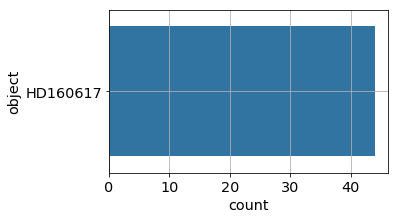

In [214]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [215]:
list_of_objects=sel2_obs['object'].values

In [216]:
list_of_objects=set(list_of_objects)

In [217]:
list_of_objects=list(list_of_objects)

In [218]:
list_of_objects_str=','.join(list_of_objects)

# Remove bad spectra

In [219]:
bad_calib_indexes=np.array([48,49,50,168])

In [220]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_calib_indexes:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f) 

 remove  reduc_20170612_048_spectrum.fits
 remove  reduc_20170612_049_spectrum.fits
 remove  reduc_20170612_050_spectrum.fits
 remove  reduc_20170612_168_spectrum.fits


### find filename for sim spectra

In [221]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [222]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [223]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/clearsky/specsim_20170612_041_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/clearsky/specsim_20170612_042_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/clearsky/specsim_20170612_044_spectrum.fits']

In [224]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [225]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/standard/specsim_20170612_041_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/standard/specsim_20170612_042_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/standard/specsim_20170612_044_spectrum.fits']

In [226]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [227]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/merra2/specsim_20170612_041_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/merra2/specsim_20170612_042_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/merra2/specsim_20170612_044_spectrum.fits']

# Remove bad indexes

In [228]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170612_041_spectrum.fits
 remove  reduc_20170612_042_spectrum.fits
 remove  reduc_20170612_044_spectrum.fits
 remove  reduc_20170612_052_spectrum.fits
 remove  reduc_20170612_053_spectrum.fits
 remove  reduc_20170612_054_spectrum.fits
 remove  reduc_20170612_055_spectrum.fits
 remove  reduc_20170612_056_spectrum.fits
 remove  reduc_20170612_057_spectrum.fits
 remove  reduc_20170612_058_spectrum.fits
 remove  reduc_20170612_059_spectrum.fits
 remove  reduc_20170612_064_spectrum.fits
 remove  reduc_20170612_065_spectrum.fits
 remove  reduc_20170612_066_spectrum.fits
 remove  reduc_20170612_067_spectrum.fits
 remove  reduc_20170612_068_spectrum.fits
 remove  reduc_20170612_069_spectrum.fits
 remove  reduc_20170612_070_spectrum.fits
 remove  reduc_20170612_071_spectrum.fits
 remove  reduc_20170612_076_spectrum.fits
 remove  reduc_20170612_077_spectrum.fits
 remove  reduc_20170612_078_spectrum.fits
 remove  reduc_20170612_079_spectrum.fits
 remove  reduc_20170612_080_spectr

In [229]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170612_041_spectrum.fits
 remove  specsim_20170612_042_spectrum.fits
 remove  specsim_20170612_044_spectrum.fits
 remove  specsim_20170612_052_spectrum.fits
 remove  specsim_20170612_053_spectrum.fits
 remove  specsim_20170612_054_spectrum.fits
 remove  specsim_20170612_055_spectrum.fits
 remove  specsim_20170612_056_spectrum.fits
 remove  specsim_20170612_057_spectrum.fits
 remove  specsim_20170612_058_spectrum.fits
 remove  specsim_20170612_059_spectrum.fits
 remove  specsim_20170612_064_spectrum.fits
 remove  specsim_20170612_065_spectrum.fits
 remove  specsim_20170612_066_spectrum.fits
 remove  specsim_20170612_067_spectrum.fits
 remove  specsim_20170612_068_spectrum.fits
 remove  specsim_20170612_069_spectrum.fits
 remove  specsim_20170612_070_spectrum.fits
 remove  specsim_20170612_071_spectrum.fits
 remove  specsim_20170612_076_spectrum.fits
 remove  specsim_20170612_077_spectrum.fits
 remove  specsim_20170612_078_spectrum.fits
 remove  specsim_20170612_079_sp

In [230]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170612_041_spectrum.fits
 remove  specsim_20170612_042_spectrum.fits
 remove  specsim_20170612_044_spectrum.fits
 remove  specsim_20170612_052_spectrum.fits
 remove  specsim_20170612_053_spectrum.fits
 remove  specsim_20170612_054_spectrum.fits
 remove  specsim_20170612_055_spectrum.fits
 remove  specsim_20170612_056_spectrum.fits
 remove  specsim_20170612_057_spectrum.fits
 remove  specsim_20170612_058_spectrum.fits
 remove  specsim_20170612_059_spectrum.fits
 remove  specsim_20170612_064_spectrum.fits
 remove  specsim_20170612_065_spectrum.fits
 remove  specsim_20170612_066_spectrum.fits
 remove  specsim_20170612_067_spectrum.fits
 remove  specsim_20170612_068_spectrum.fits
 remove  specsim_20170612_069_spectrum.fits
 remove  specsim_20170612_070_spectrum.fits
 remove  specsim_20170612_071_spectrum.fits
 remove  specsim_20170612_076_spectrum.fits
 remove  specsim_20170612_077_spectrum.fits
 remove  specsim_20170612_078_spectrum.fits
 remove  specsim_20170612_079_sp

In [231]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170612_041_spectrum.fits
 remove  specsim_20170612_042_spectrum.fits
 remove  specsim_20170612_044_spectrum.fits
 remove  specsim_20170612_052_spectrum.fits
 remove  specsim_20170612_053_spectrum.fits
 remove  specsim_20170612_054_spectrum.fits
 remove  specsim_20170612_055_spectrum.fits
 remove  specsim_20170612_056_spectrum.fits
 remove  specsim_20170612_057_spectrum.fits
 remove  specsim_20170612_058_spectrum.fits
 remove  specsim_20170612_059_spectrum.fits
 remove  specsim_20170612_064_spectrum.fits
 remove  specsim_20170612_065_spectrum.fits
 remove  specsim_20170612_066_spectrum.fits
 remove  specsim_20170612_067_spectrum.fits
 remove  specsim_20170612_068_spectrum.fits
 remove  specsim_20170612_069_spectrum.fits
 remove  specsim_20170612_070_spectrum.fits
 remove  specsim_20170612_071_spectrum.fits
 remove  specsim_20170612_076_spectrum.fits
 remove  specsim_20170612_077_spectrum.fits
 remove  specsim_20170612_078_spectrum.fits
 remove  specsim_20170612_079_sp

# which filters

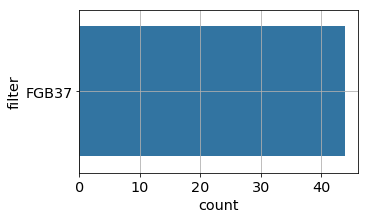

In [232]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

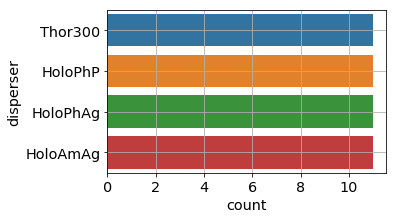

In [233]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [234]:
sel_obs_Ron200=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron200'])]

In [235]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [236]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [237]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [238]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

In [239]:
# filtering width
Wwidth=11
# Bin width
Bwidth=10

## Original SED

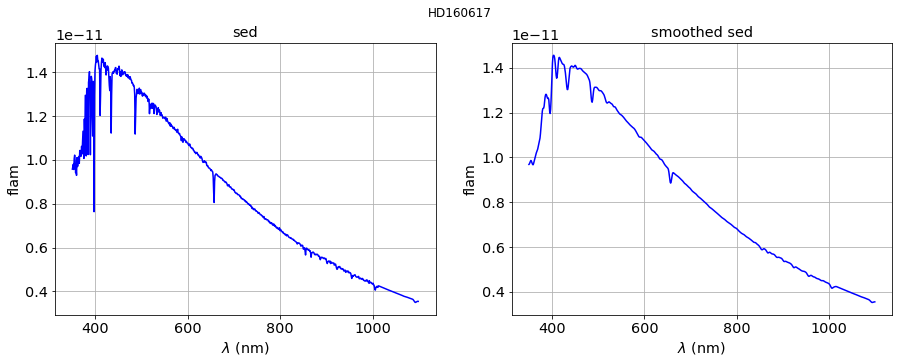

In [240]:
PlotSED(list_of_objects_str,Wwidth=Wwidth,sedunit='flam',scale='lin')

In [241]:
#PlotSED(list_of_objects_str,sedunit='photlam',scale='log')

In [242]:
#PlotSED(list_of_objects_str,sedunit='photnu',scale='log')

<Figure size 720x360 with 0 Axes>

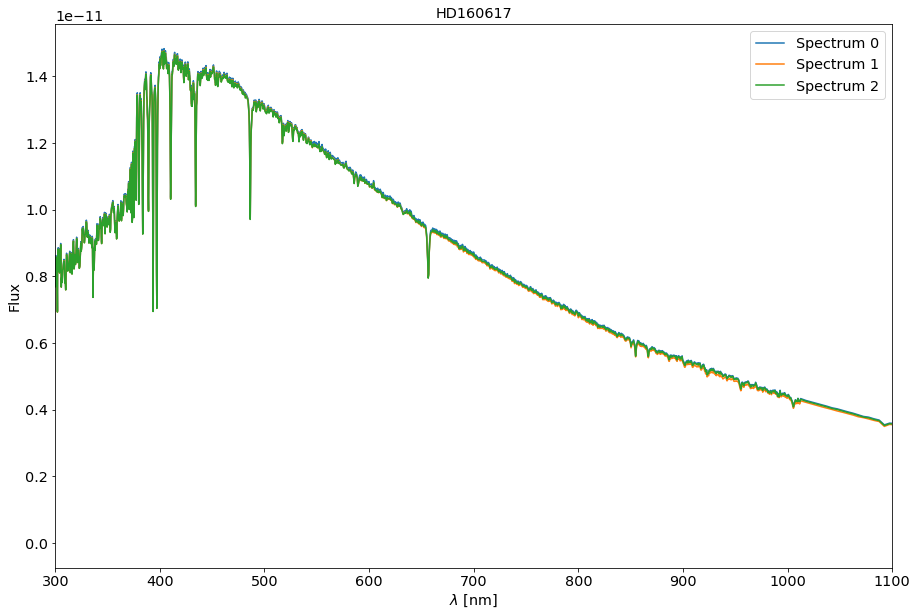

In [243]:
plt.figure(figsize=(10,5))
GetTarget(list_of_objects_str)


## Show the reconstructed spectra

In [244]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170612_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [245]:
#thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200"

In [246]:
#PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron200,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### Thor 300

In [247]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

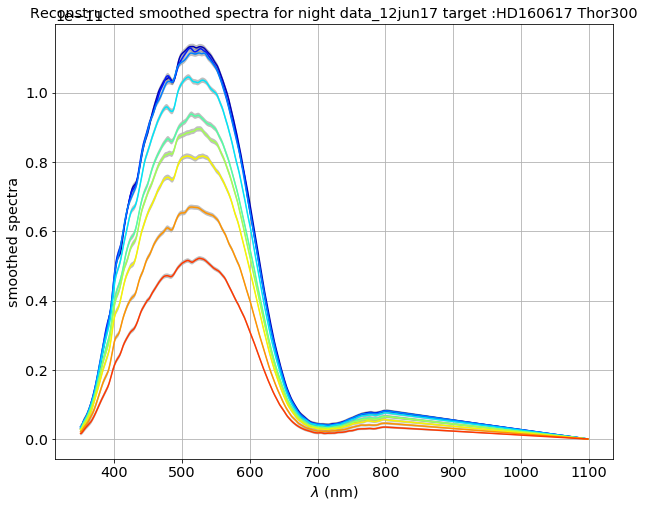

In [248]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### HoloPhP

In [249]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

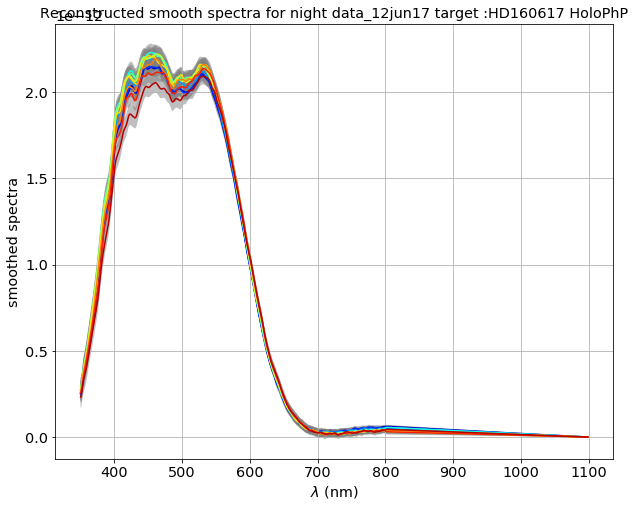

In [250]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### HoloPhAg

In [251]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

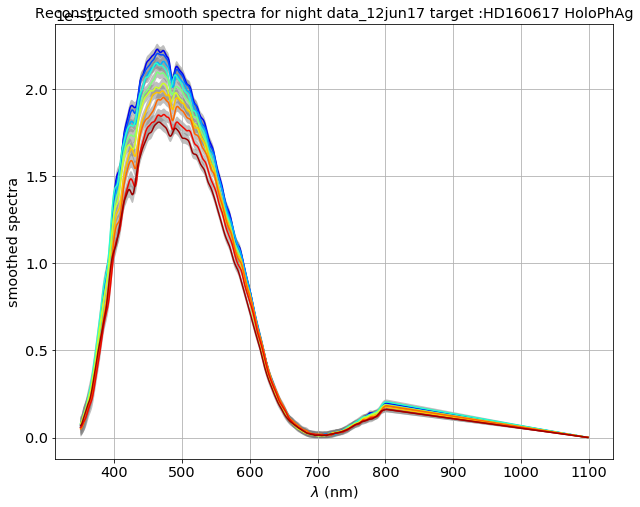

In [252]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### HoloAmAg

In [253]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

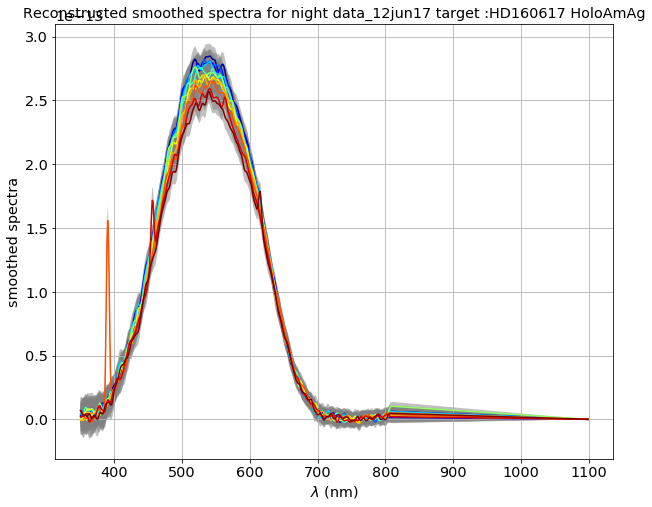

In [254]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

## Show the simulated spectra

In [255]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [256]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

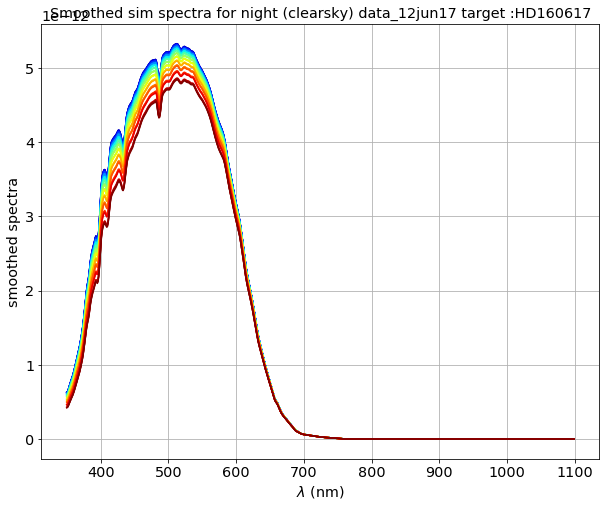

In [257]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=Wwidth)

### standard sky

In [258]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

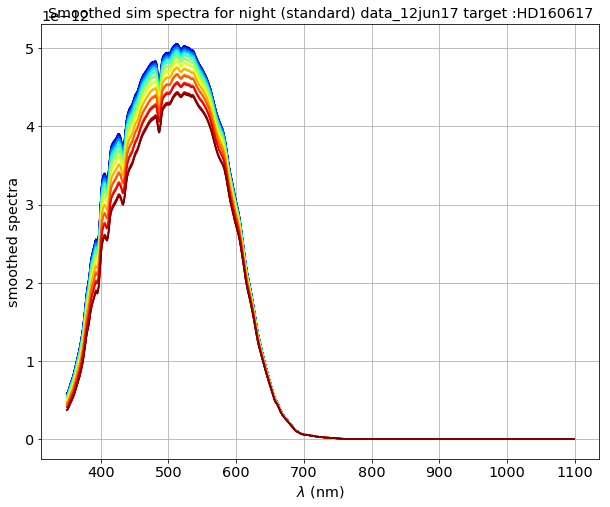

In [259]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=Wwidth)

### merra2 sky

In [260]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

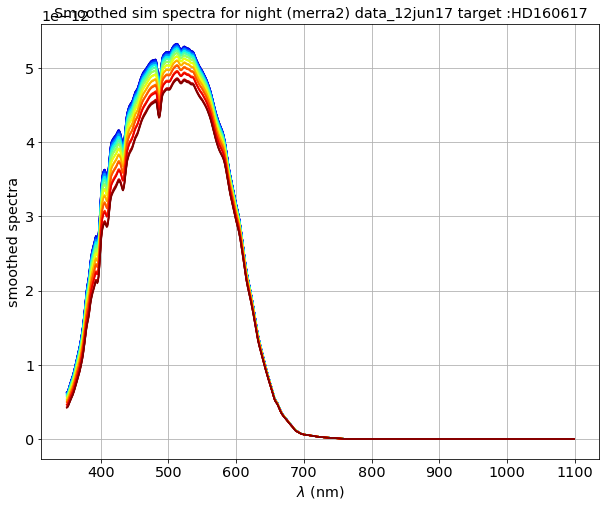

In [261]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=Wwidth)

# Airmass vs image index

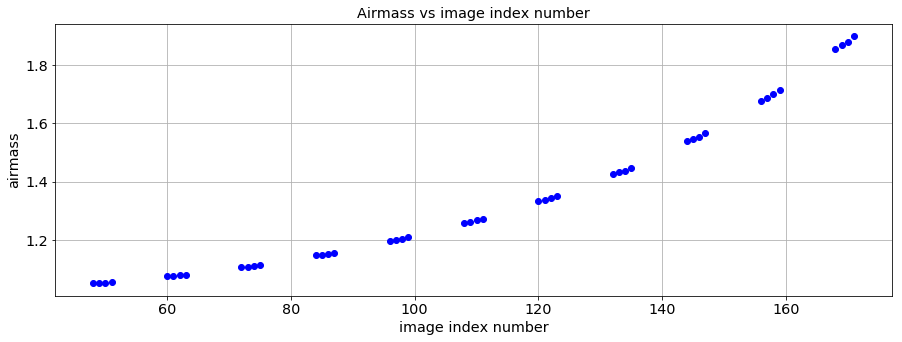

In [262]:
plt.figure(figsize=(15,5))
plt.plot(sel2_obs["index"],Convert_InFloat(sel2_obs["airmass"]),'bo')
plt.xlabel("image index number")
plt.ylabel("airmass")
plt.title('Airmass vs image index number')
plt.grid()

# Attenuation

In [263]:
# filtering width
Wwidth=11
# Bin width
Bwidth=10

In [264]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ronchi 400

In [265]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

In [266]:
sel_obs_Ron200_Red=sel_obs_Ron200[sel_obs_Ron200["filter"]=='RG715']
sel_obs_Ron200_Blue=sel_obs_Ron200[sel_obs_Ron200["filter"]=='FGB37']

In [267]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [268]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [269]:
thetitle="Binned Ratio Attenuation 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200+Blue Filter"

2018-05-18 21:03:56  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


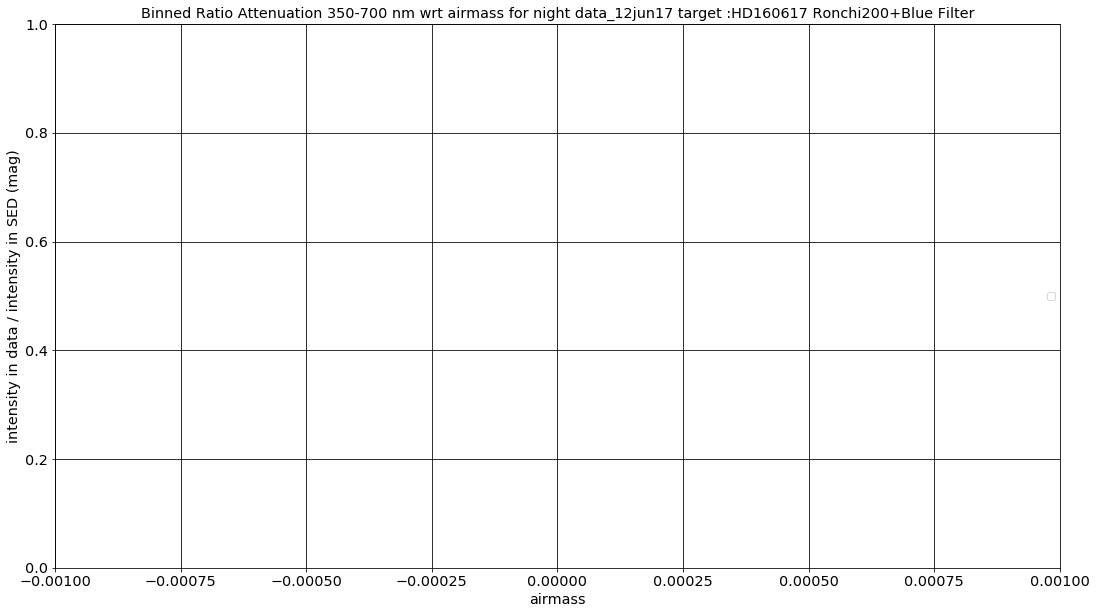

In [270]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Ron200_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth)   

In [271]:
thetitle="Binned Ratio Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200+ Red Filter"

2018-05-18 21:03:56  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


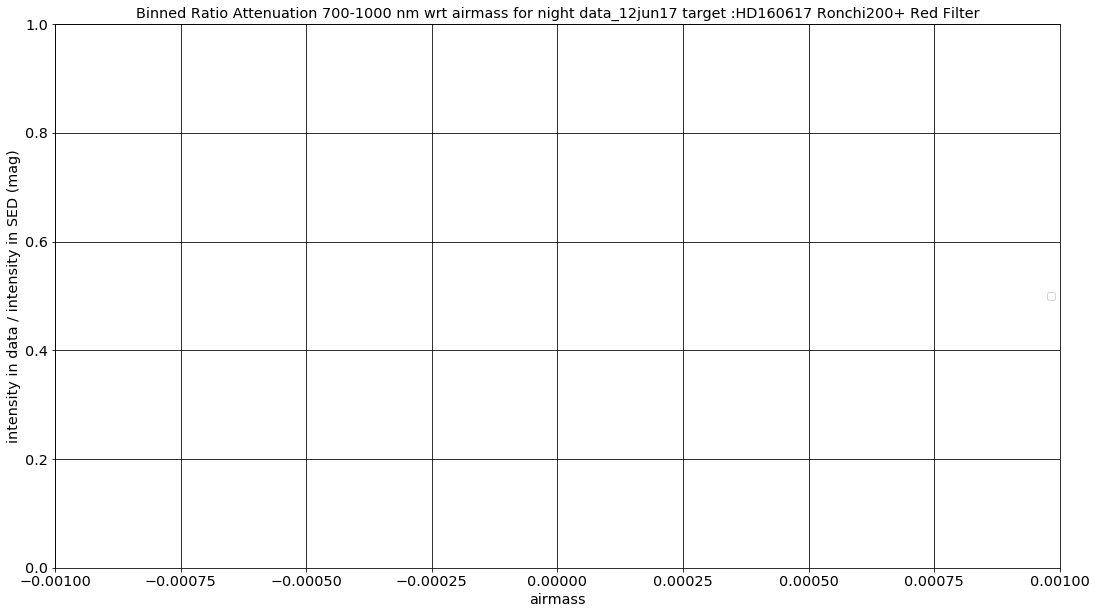

In [272]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Ron200_Red,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth) 

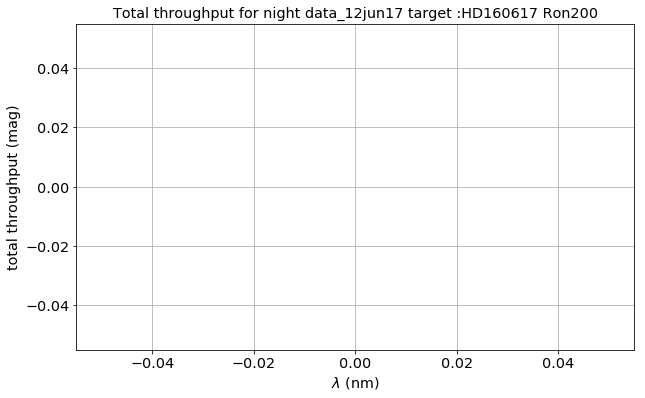

In [273]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ron200"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [274]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_Ron300.csv")
df.head()

Empty DataFrame
Columns: [wl, thrpt, err]
Index: []

## Thor300

In [275]:
#sel_obs_Thor300_Red=sel_obs_Thor300[sel_obs_Thor300["filter"]=='RG715']
#sel_obs_Thor300_Blue=sel_obs_Thor300[sel_obs_Thor300["filter"]=='FGB37']

In [276]:
#sel_obs_Thor300_Blue

In [277]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300 + Blue Filter"

In [278]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [279]:
thetitle="Binned Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300+ Blue Filter"

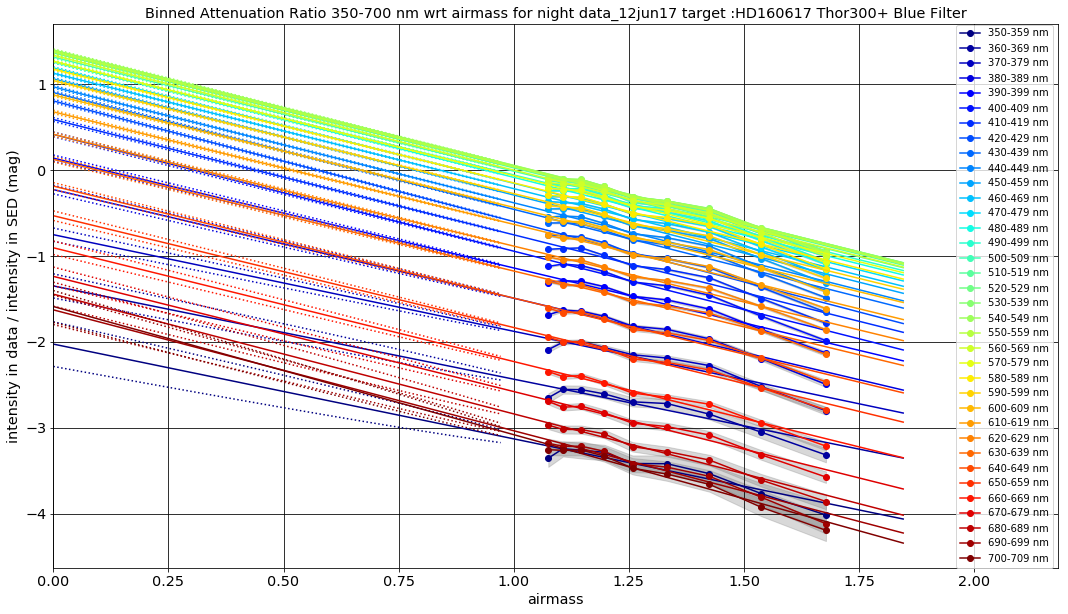

In [280]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth)   

In [281]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300 + Red Filter"

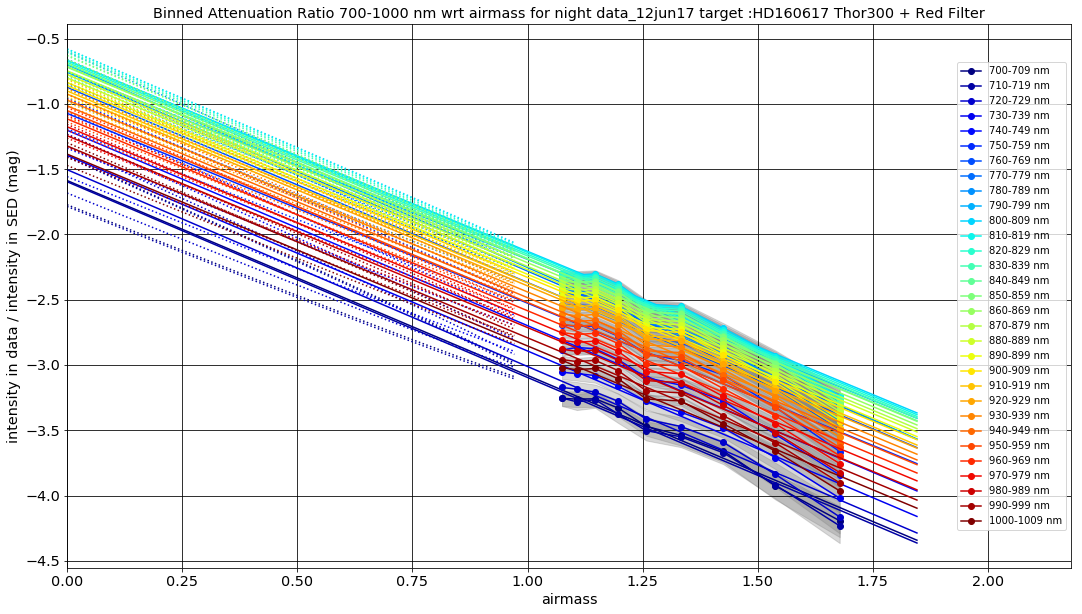

In [282]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

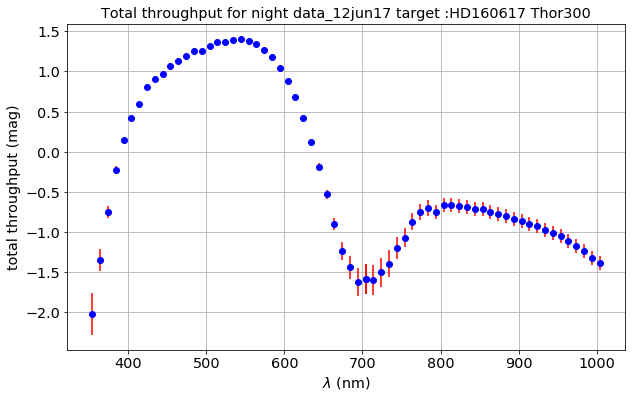

In [283]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [284]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_Thor300.csv")
df.head()

wl     thrpt       err
0  354.0 -2.025210  0.260091
1  364.0 -1.348117  0.140605
2  374.0 -0.751578  0.077624
3  384.0 -0.226524  0.049747
4  394.0  0.139539  0.036231

## HoloPhP

In [285]:
thetitle="Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

In [286]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [287]:
thetitle="Binned Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP+ Blue Filter"

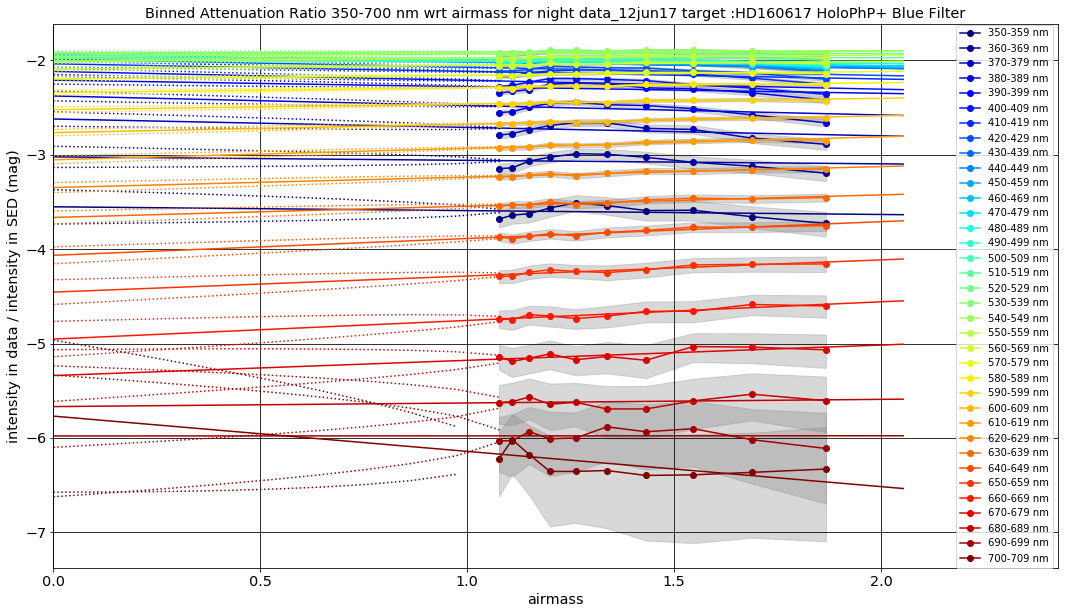

In [288]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth)   

In [289]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP+Red Filter"

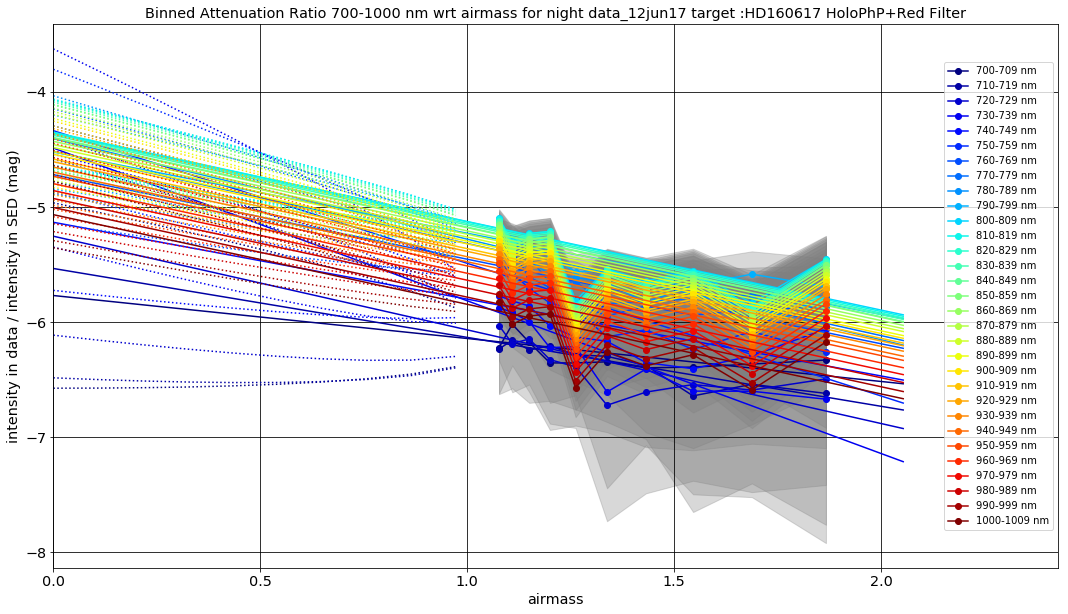

In [290]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

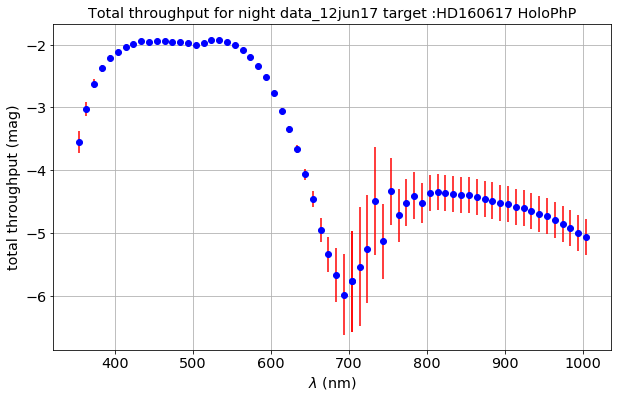

In [291]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [292]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_HoloPhP.csv")
df.head()

wl     thrpt       err
0  354.0 -3.551270  0.181871
1  364.0 -3.022464  0.112423
2  374.0 -2.621489  0.076418
3  384.0 -2.377542  0.051637
4  394.0 -2.210009  0.041362

## HoloPhAg

In [293]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [294]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [295]:
thetitle="Binned Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg+ Blue Filter"

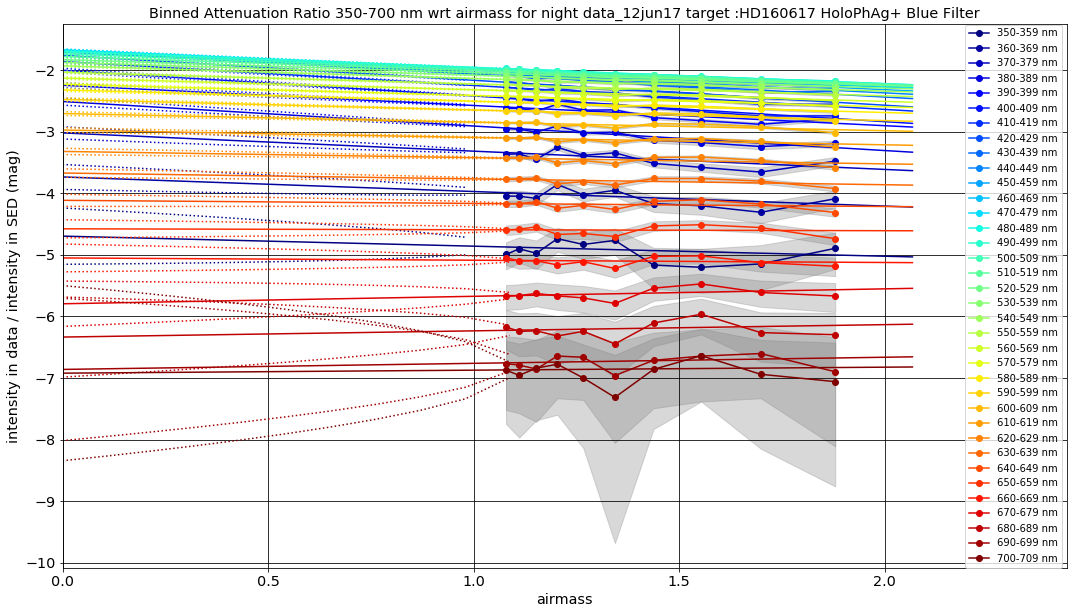

In [296]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth)   

In [297]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg+Red Filter"

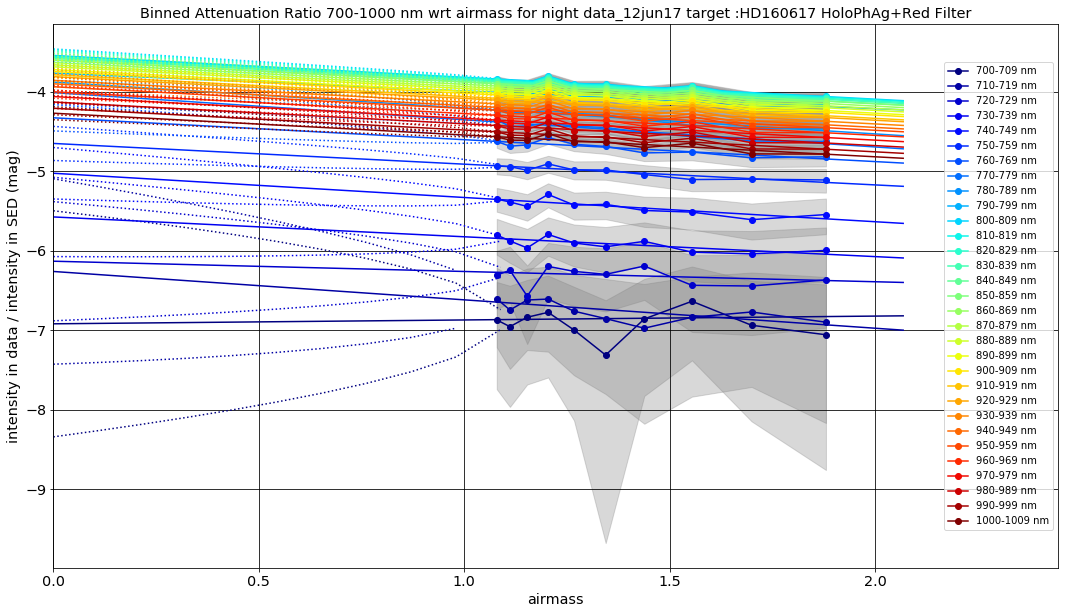

In [298]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

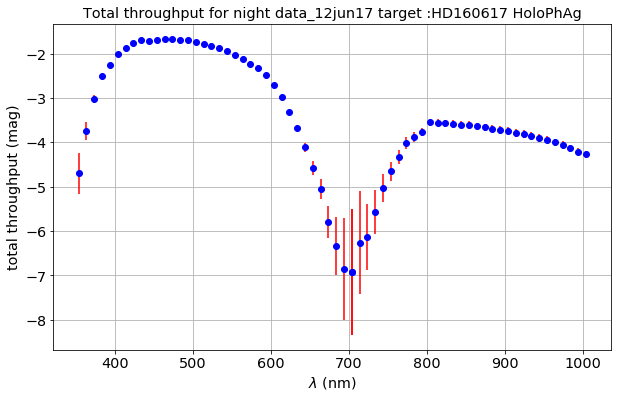

In [299]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [300]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_HoloPhAg.csv")
df.head()

wl     thrpt       err
0  354.0 -4.695743  0.457231
1  364.0 -3.735210  0.202697
2  374.0 -3.020443  0.098508
3  384.0 -2.510644  0.059347
4  394.0 -2.247337  0.041304

## HoloAmAg

In [301]:
thetitle="Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

In [302]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [303]:
thetitle="Binned Attenuation Ratio 400-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg+Blue Filter"

bad_bins [3]


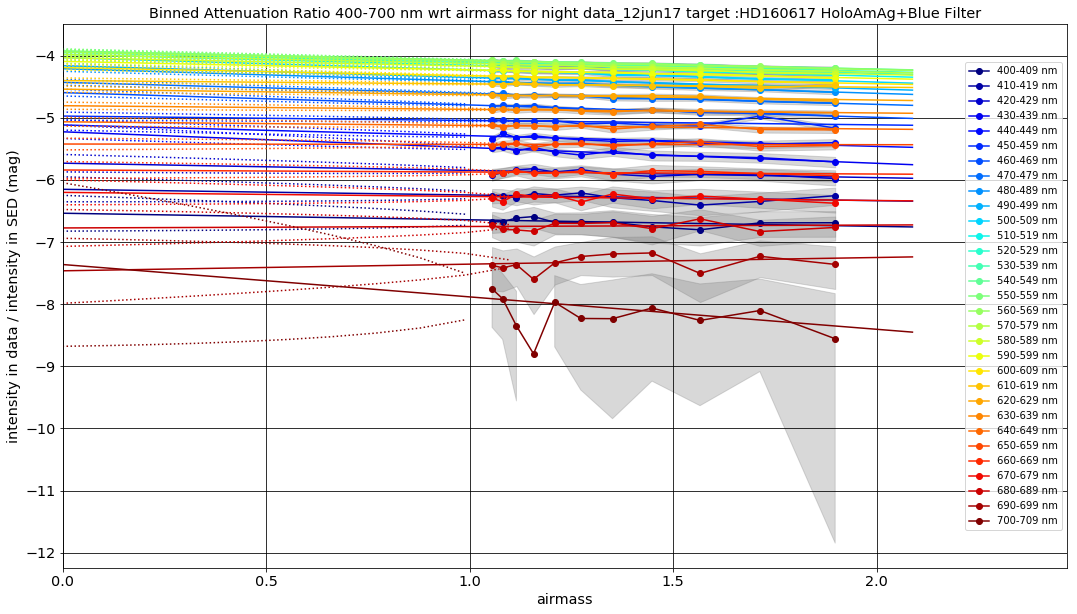

In [304]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth)   

In [305]:
thetitle="Binned Attenuation Ratio 800-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg+Red Filter"

bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]
bad_bins [1 6 9]


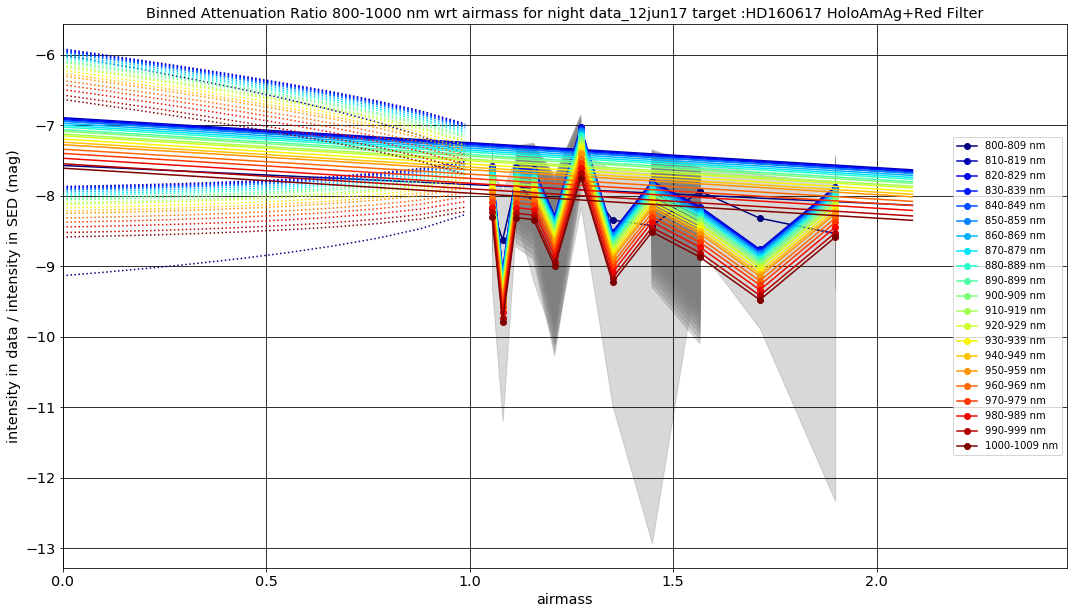

In [306]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=800,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

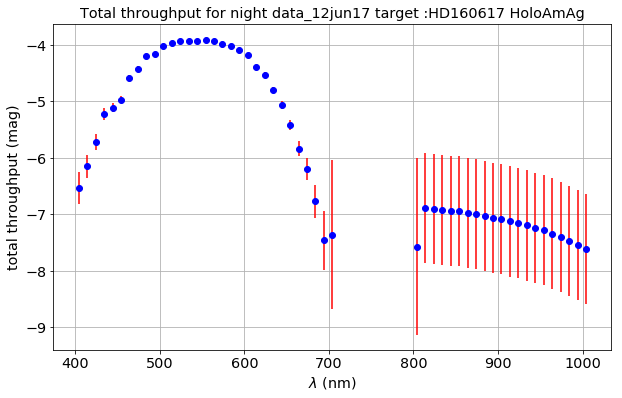

In [307]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [308]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_HoloAmAg.csv")
df.head()

wl     thrpt       err
0  404.0 -6.536353  0.288123
1  414.0 -6.151337  0.200922
2  424.0 -5.730720  0.140312
3  434.0 -5.225657  0.107990
4  444.0 -5.115972  0.082586

# Simulation

In [309]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [310]:
#SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

## Simulation with ClearSky

In [311]:
thetitle="Attenuation Ratio 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky+ Blue Filter"

In [312]:
#FitSpectraDataSimAttenuationRatioSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [313]:
thetitle="Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky+Blue Filter"

In [314]:
#FitSpectraDataSimAttenuationRatioSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=51)   

In [315]:
thetitle="Binned Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky+Blue Filter"

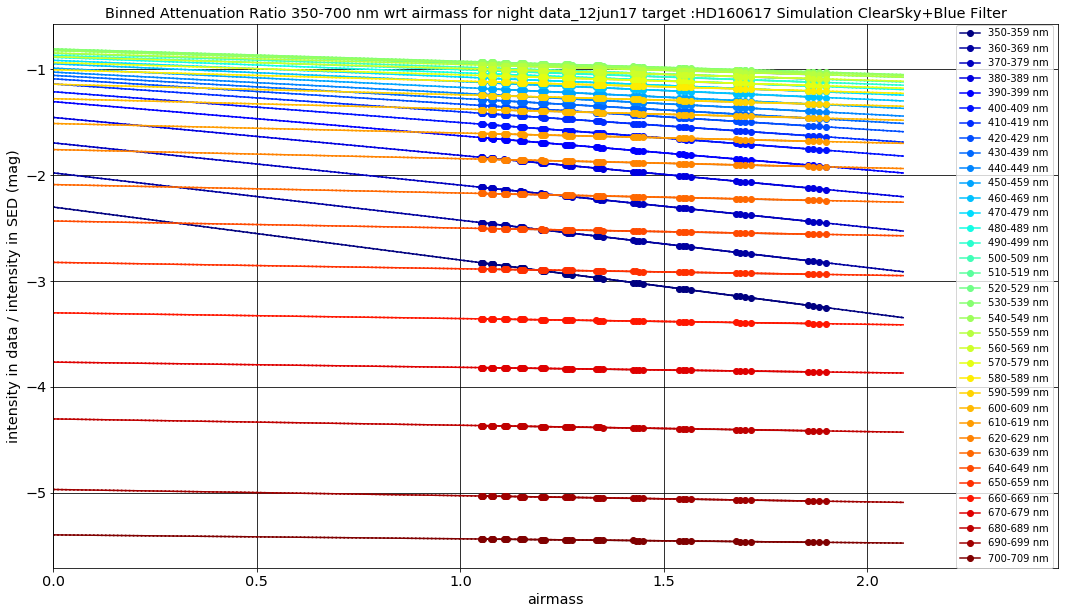

In [316]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth) 

In [317]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky+Red Filter"

In [318]:
#wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth) 

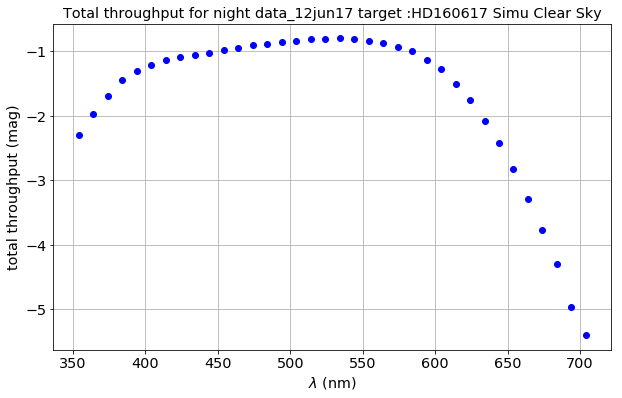

In [319]:
#wl=np.concatenate((wl1,wl2))
#thrpt=np.concatenate((y1,y2))
#err=np.concatenate((ey1,ey2))
wl=wl1
thrpt=y1
err=ey1
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simu Clear Sky"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [320]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_SimClearSky.csv")
df.head()

wl     thrpt  err
0  354.0 -2.300154  0.0
1  364.0 -1.976950  0.0
2  374.0 -1.693599  0.0
3  384.0 -1.453193  0.0
4  394.0 -1.303883  0.0

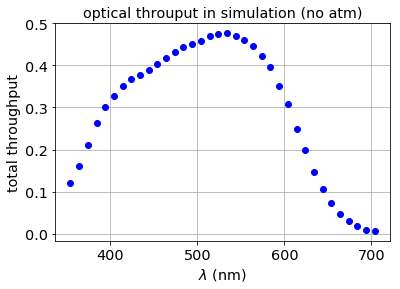

In [321]:
plt.title('optical throuput in simulation (no atm)')
plt.plot(wl,np.power(10,thrpt/2.5),'bo')
plt.xlabel('$\lambda$ (nm)' )
plt.ylabel('total throughput')
plt.grid(b=True, which='both')

## Simulation with average Sky

In [322]:
thetitle="Binned Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

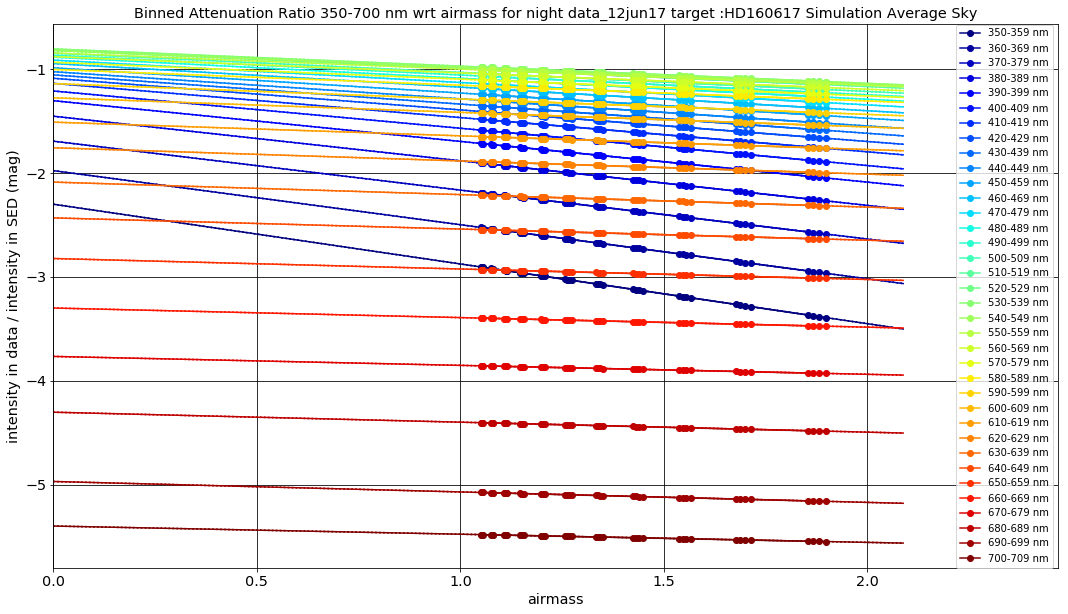

In [323]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth) 

In [324]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

In [325]:
#wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles2,sel2_obs_Red,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth) 

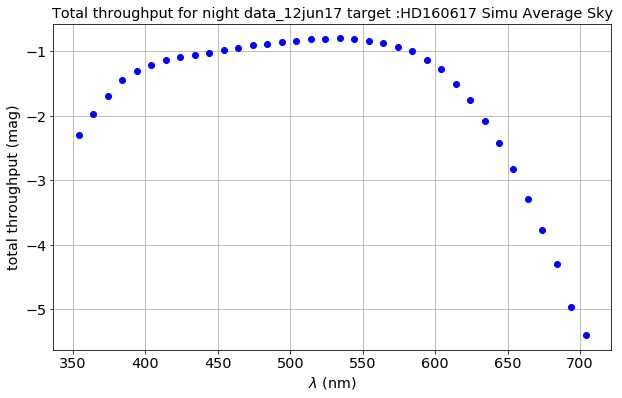

In [326]:
#wl=np.concatenate((wl1,wl2))
#thrpt=np.concatenate((y1,y2))
#err=np.concatenate((ey1,ey2))
wl=wl1
thrpt=y1
err=ey1
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simu Average Sky"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [327]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_SimAverSky.csv")
df.head()

wl     thrpt  err
0  354.0 -2.300165  0.0
1  364.0 -1.976964  0.0
2  374.0 -1.693610  0.0
3  384.0 -1.453203  0.0
4  394.0 -1.303892  0.0

## Simulation with MERRA2 Sky

In [328]:
thetitle="Binned Attenuation Ratio 350-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky"

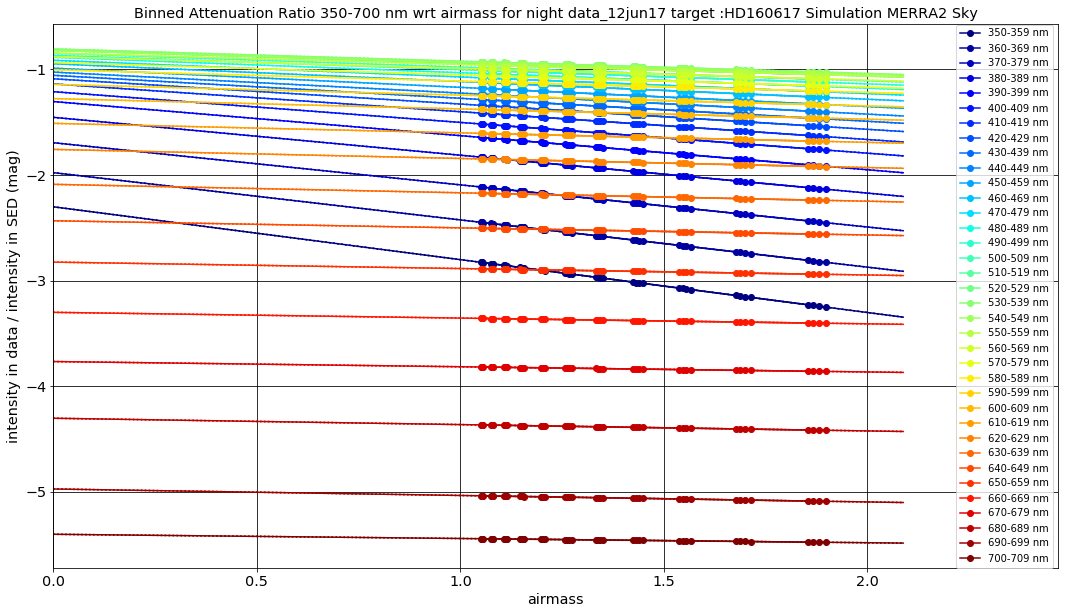

In [329]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth) 

In [330]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky"

In [331]:
#wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth) 

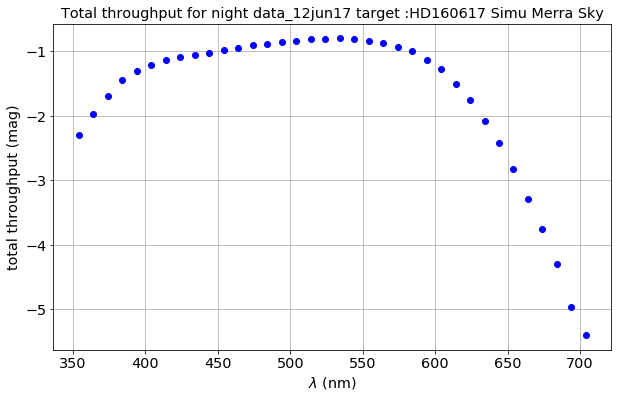

In [332]:
#wl=np.concatenate((wl1,wl2))
#thrpt=np.concatenate((y1,y2))
#err=np.concatenate((ey1,ey2))
wl=wl1
thrpt=y1
err=ey1
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simu Merra Sky"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [333]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_SimMerra2Sky.csv")
df.head()

wl     thrpt  err
0  354.0 -2.300154  0.0
1  364.0 -1.976950  0.0
2  374.0 -1.693599  0.0
3  384.0 -1.453193  0.0
4  394.0 -1.303883  0.0